In [ ]:
!pip install optuna

In [182]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (train_test_split, StratifiedKFold)

from lightgbm import LGBMRegressor
import lightgbm as lgb

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances

# Reduce memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
# Reduce memory usage
df_red = reduce_mem_usage(pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/train.csv',index_col='id')
df_samp_red = reduce_mem_usage(sample_df)
df_val_red = reduce_mem_usage(pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/test.csv',index_col='id')

# Save reduced dfto drive
df_red.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/train_reduced.csv')
df_val_red.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/test_reduced.csv')

Memory usage after optimization is: 265.84 MB
Decreased by 69.7%
Memory usage after optimization is: 53.17 MB
Decreased by 69.7%
Memory usage after optimization is: 136.48 MB
Decreased by 69.5%


# Load the data

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/train_reduced.csv',index_col='id')
df_val = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/test_reduced.csv', index_col='id')

In [93]:
# sampling df bc its too big
sample_df = df.sample(int(len(df) * 0.2))

In [94]:
y = sample_df.claim
x = sample_df.drop('claim', axis=1)

In [95]:
y_full = df.claim
x_full = df.drop('claim', axis=1)

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [97]:
# Fixing Seed
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything()

# EDA

## Data Distribution

### Target

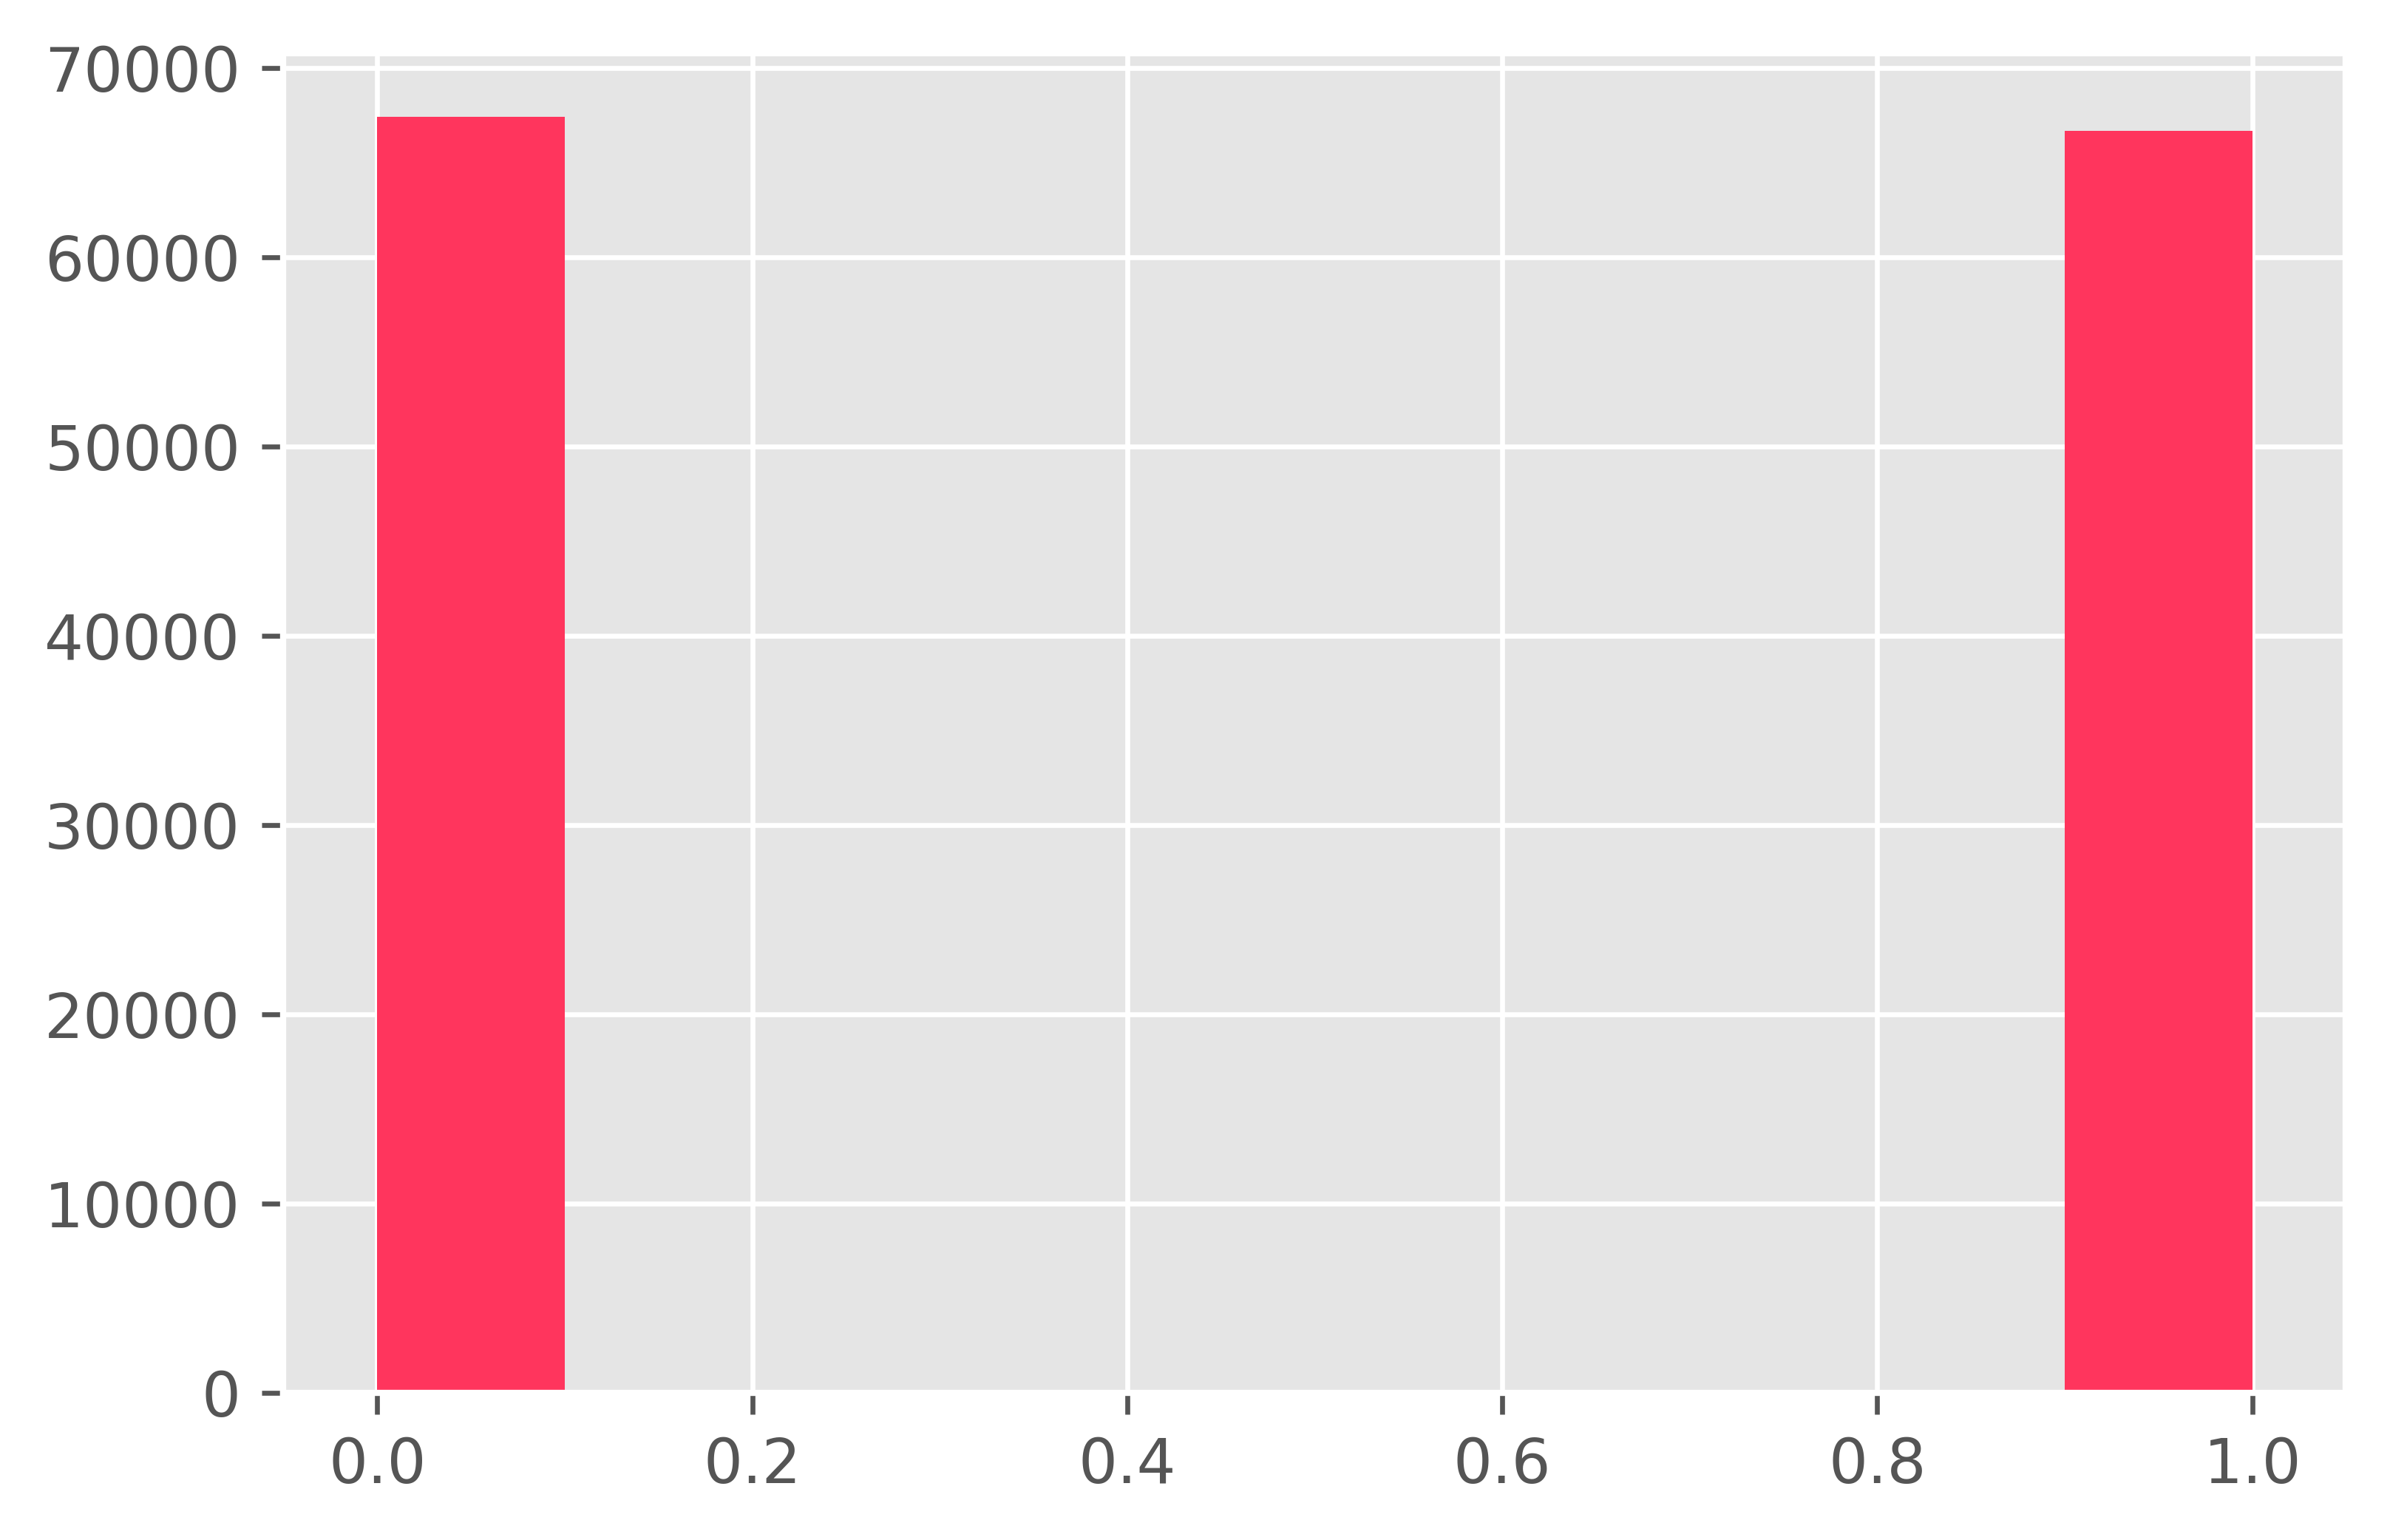

In [184]:
plt.hist(y_train)
plt.show()

Pretty well balanced

## Features

In [185]:
x_train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,132030.00000,131979.000000,131924.000000,131985.000000,131883.000000,131944.000000,131919.000000,1.319190e+05,1.318520e+05,131926.000000,131950.000000,1.318930e+05,131955.000000,132069.000000,132028.000000,131965.000000,131955.000000,132047.000000,131943.000000,131980.000000,131961.000000,132008.000000,131931.000000,131834.000000,131905.000000,1.320530e+05,1.319770e+05,1.319220e+05,131993.000000,131997.000000,131863.000000,1.318750e+05,1.319620e+05,131861.000000,1.319660e+05,131991.000000,131988.000000,131912.000000,131943.00000,131991.000000,...,131943.000000,131970.000000,131966.000000,1.319540e+05,131918.000000,1.319740e+05,131912.000000,1.319220e+05,131918.000000,131986.000000,131997.000000,132027.000000,131951.000000,131956.000000,131899.000000,131940.000000,131840.000000,131916.000000,131937.000000,1.319240e+05,131985.000000,131937.000000,131928.000000,1.320440e+05,131903.000000,132004.000000,132003.000000,131951.000000,131985.000000,1.319550e+05,131990.000000,131917.000000,131876.000000,131995.000000,131915.000000,131897.000000,131921.000000,1.319750e+05,131922.000000,131897.000000
mean,0.09007,0.345870,4043.068114,0.201443,0.305384,-0.085259,1623.397821,3.773689e+05,1.804956e+15,5337.945914,0.730554,1.843885e+09,0.247472,7.019313,0.019051,446.257392,6.893647,4.503041,22.435922,204.223961,61273.122867,2.271343,87.099686,0.343871,413.585817,3.370931e+12,1.256310e+12,2.243947e+06,0.327293,7.887974,0.394193,1.344004e+05,3.561263e+05,-0.000002,2.791532e+16,186.200094,406.374553,1.772616,1978.01776,0.359379,...,1.564416,0.194611,3.234991,1.050501e+11,152.070562,6.072234e+06,637.171651,3.239983e+10,26.518365,206.885124,3797.473169,6.726174,0.366537,4859.933362,132.419369,0.822514,13.079521,3826.659711,0.999974,1.414075e+13,1.681554,0.425652,20.239157,3.211867e+05,545.602168,3829.086681,0.178139,0.161116,0.014216,1.677665e+09,0.398821,-19.962639,2.074058,23.860541,1.771756,62979.389288,1.208282,4.308696e+16,3951.827515,0.561137
std,0.04347,0.146103,6386.348226,0.213427,0.145307,2.123972,1277.416956,3.445272e+05,2.328299e+15,10072.259861,1.492319,2.128383e+09,0.101625,6.647826,0.101999,632.299502,1.716485,3.893544,14.576975,281.353217,90225.004377,0.901368,37.489744,1.641824,314.753349,5.646756e+12,1.642815e+12,2.300827e+06,0.433314,5.910980,0.785743,2.041823e+05,4.609633e+05,0.001535,3.458662e+16,701.989739,314.621066,0.591939,1956.88765,0.441812,...,9.132364,0.162074,1.986971,9.853170e+10,227.648763,8.720616e+06,583.841001,3.066236e+10,25.406959,158.298242,3524.524384,3.154143,0.146419,8406.867385,110.037330,0.712434,12.717997,6423.701765,0.001578,1.636242e+13,0.711384,0.283272,19.701076,3.272085e+05,862.461521,6636.175334,0.123186,0.141702,0.016262,1.878687e+09,0.298543,18.570269,0.897474,45.652248,10.104418,92063.509470,0.114560,6.754217e+16,3146.528532,0.409367
min,-0.14320,-0.018360,-8260.000000,-0.061100,-0.006935,-12.570000,-205.000000,-2.666600e+04,-1.008500e+15,-23062.000000,-7.960000,-3.856300e+08,-0.082400,-0.854000,-0.335700,-106.800000,-3.434000,-0.065550,-3.930000,-52.970000,-76676.000000,-5.880000,-17.920000,-5.590000,-63.200000,-6.867600e+11,-9.213900e+11,-4.102800e+05,-0.005550,-0.463100,-3.800000,-3.326000e+05,-5.133200e+05,-0.003857,-1.912700e+16,-2372.000000,-40.880000,0.580600,-332.50000,-0.007590,...,-23.640000,-0.014330,0.964400,-5.230900e+10,-27.730000,-2.608400e+06,-66.600000,-5.934200e+09,-7.363000,-21.140000,-296.800000,-0.174300,-0.012080,-12584.000000,-12.010000,-3.027000,-1.270500,-7332.000000,0.996000,-4.511300e+12,0.718800,-0.031950,-4.207000,-1.606000e+05,-201.400000,-9280.000000,-0.027540,-0.039300,-0.007280,-5.390500e+08,-0.030270,-105.560000,0.312300,-25.02

NameError: ignored

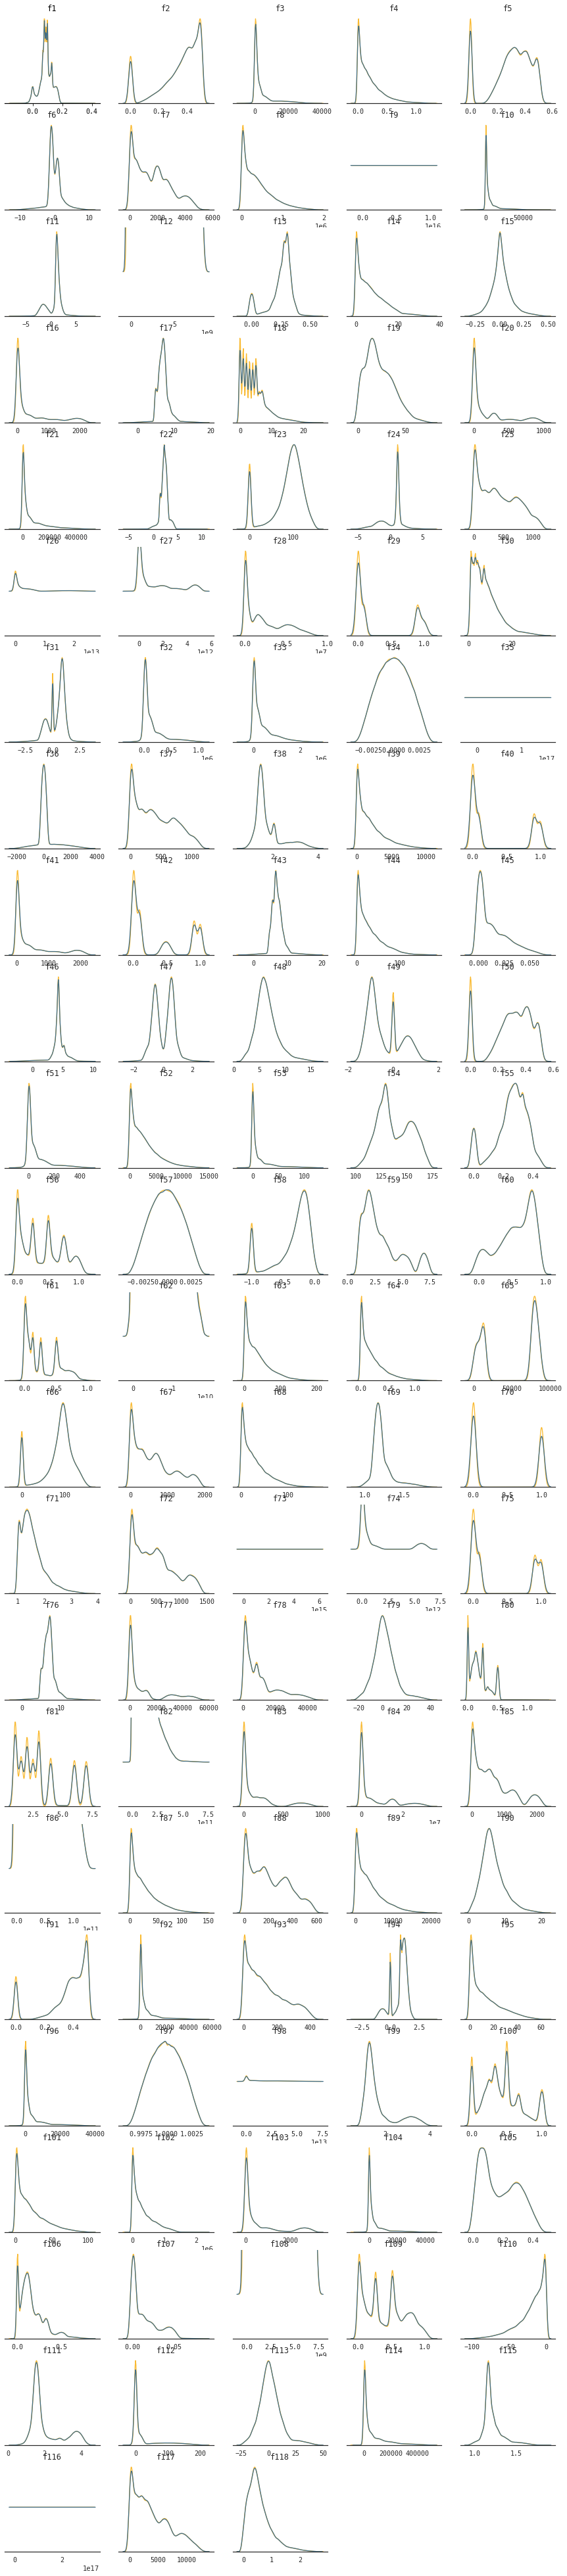

In [ ]:
df_samp_red = pd.concat([x_train, y_train], axis=1,)
df_val_red = pd.concat([x_test, y_test], axis=1,)

fig = plt.figure(figsize = (15, 71))
cols = train.columns.tolist()[1:119]
for i in cols:
    plt.subplot(24,5,cols.index(i)+1)
    sns.set_style("white")
    plt.title(i, size = 12, fontname = 'monospace')
    a = sns.kdeplot(train[i], color = '#f9ba32', linewidth = 1.3)
    sns.kdeplot(test[i], color = '#426e86', linewidth = 1.3)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)

plt.figtext(0.335, 1.02, 'Distribution of features', color = '#2f3131', fontname = 'monospace', size = 25)
plt.figtext(0.3, 1.01, 'train', color = '#f9ba32', fontname = 'monospace', size = 18)
plt.figtext(0.66, 1.01, 'test', color = '#426e86', fontname = 'monospace', size = 18)

plt.show()

## Missing Data

In [112]:
#plot bars with white stripes for missing values
msno.matrix(x_train)

In [110]:
missing_train_df = pd.DataFrame(df.isna().sum())
missing_train_df = missing_train_df.drop(['claim']).reset_index()
missing_train_df.columns = ['feature', 'count']

missing_test_df = pd.DataFrame(df_val.isna().sum())
missing_test_df = missing_test_df.reset_index()
missing_test_df.columns = ['feature', 'count']

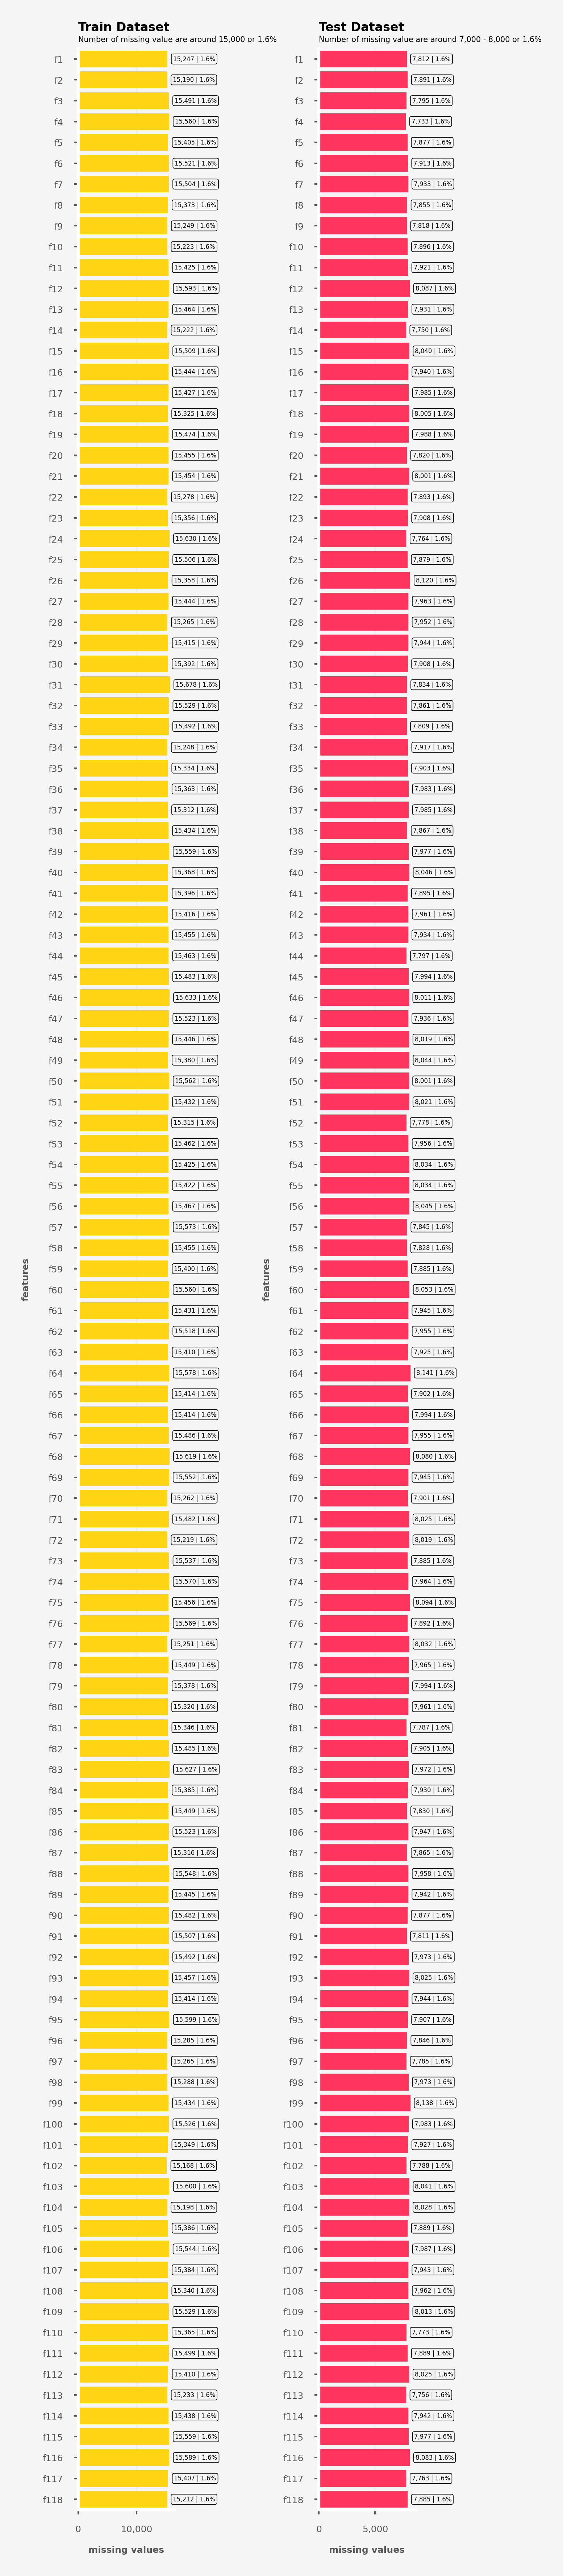

In [111]:
#code copied from https://www.kaggle.com/dwin183287/tps-september-2021-eda/comments#Table-of-Contents

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(2, 15), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 2)
gs.update(wspace=1.5, hspace=0.05)

background_color = "#f6f5f5"
sns.set_palette(['#ffd514']*120)

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.barplot(ax=ax0, y=missing_train_df['feature'], x=missing_train_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax0_sns.set_ylabel("features",fontsize=3, weight='bold')
ax0_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0.text(0, -1.8, 'Train Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax0.text(0, -1.105, 'Number of missing value are around 15,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax0.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 1000
    y = p.get_y() + p.get_height() / 2 
    ax0.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))
    
background_color = "#f6f5f5"
sns.set_palette(['#ff355d']*120)
    
ax3 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax3.spines[s].set_visible(False)
ax3.set_facecolor(background_color)
ax3_sns = sns.barplot(ax=ax3, y=missing_test_df['feature'], x=missing_test_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax3_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax3_sns.set_ylabel("features",fontsize=3, weight='bold')
ax3_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax3_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3.text(0, -1.8, 'Test Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax3.text(0, -1.105, 'Number of missing value are around 7,000 - 8,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax3.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df_val.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 500
    y = p.get_y() + p.get_height() / 2 
    ax3.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))

#t-SNE and UMAP - TBC

https://www.kaggle.com/lucamassaron/really-not-missing-at-random


Next steps:
test using UMAP output as predict features

In [ ]:
from cuml.manifold import TSNE, UMAP

# Model Selection

## XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb.fit(x_train,y_train)
pred_xgb = xgb.predict(x_test)

[18:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'XGBoost: AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_xgb)*100,3)}%') #qt

XGBoost: AUC of ROC Score: 79.362%


XGBoost is taking too long to run, LGBM kick it's a** in performance.

## LighGBM

##Baseline

In [ ]:
lgbm_reg = LGBMRegressor(random_state=42)

lgbm_reg.fit(x_train,y_train) # eval_set=(x_test, y_test), eval_metric='roc_auc',verbose=False)
pred_lgbm_reg = lgbm_reg.predict(x_test)

In [ ]:
print(f'LGBM baseline with qt: AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_lgbm_reg)*100,3)}%')

LGBM baseline with qt: AUC of ROC Score: 80.054%


In [59]:
lgbm_class = LGBMClassifier(random_state=42)

lgbm_class.fit(x_train,y_train) # eval_set=(x_test, y_test), eval_metric='roc_auc',verbose=False)
pred_lgbm_class = lgbm_class.predict_proba(x_test)

In [62]:
print(f'LGBM baseline with qt: AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_lgbm_class[:,1])*100,3)}%')

LGBM baseline with qt: AUC of ROC Score: 80.08%


# Feature Engeneer

In [11]:
class sum_missing(BaseEstimator, TransformerMixin):
  """Creates a columns with the sum of amount of missing value per row"""

  def __init__(self):
    pass
  
  def fit(self,x:pd.DataFrame ,y:pd.Series=None):
    return self

  def transform(self, df:pd.DataFrame):
    x = df.copy()
    x['sum_missing'] = x.isna().sum(axis=1)
    return x

class std_col(BaseEstimator, TransformerMixin):
  """Creates a columns with the standard deviation of each row"""

  def __init__(self):
    pass
  
  def fit(self,x:pd.DataFrame ,y:pd.Series=None):
    return self

  def transform(self, df:pd.DataFrame):
    x = df.copy()
    x['std'] = x.std(axis=1)
    return x

In [125]:
# Pre-processing pipeline
pipe_pp = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True))

x_train_pp = pipe_pp.fit_transform(x_train)
x_test_pp = pipe_pp.fit_transform(x_test)

In [183]:
LGBMClassifier(random_state=42).fit(x_train_pp, y_train)
pred_fe = lgbm_class.predict_proba(x_test_pp)
print(f'LGBM with missing indicator AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_fe[:,1])*100,3)}%')

LGBM with missing indicator AUC of ROC Score: 80.424%


## Cross val

In [179]:
def manual_cross(X,y, N_SPLITS, params):
  
  X = X.reset_index()
  y = y.reset_index().iloc[:,1]
  strat_kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

  scores = np.empty(N_SPLITS)
  for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
      print("=" * 12 + f"Training fold {idx}" + 12 * "=")
      start = time.time()

      X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_val = y[train_idx], y[test_idx]
      eval_set = [(X_val, y_val)]

      lgbm_clf = LGBMClassifier(**params)
      lgbm_clf.fit(
          X_train,
          y_train,
          eval_set=eval_set,
          early_stopping_rounds=200,
          eval_metric="binary_logloss",
          verbose=False,
      )

      preds = lgbm_clf.predict_proba(X_val)
      fold_score = roc_auc_score(y_val, preds[:,1])
      scores[idx] = fold_score
      runtime = time.time() - start
      print(f"Fold {idx} finished with score: {fold_score:.5f} in {runtime:.2f} seconds.\n")
  print(f'Mean score of folds {scores.mean()}')

In [180]:
manual_cross(x_train,y_train,5, best_lgbm_params)

============Training fold 0============
Fold 0 finished with score: 0.79782 in 51.76 seconds.

============Training fold 1============
Fold 1 finished with score: 0.79665 in 51.76 seconds.

============Training fold 2============
Fold 2 finished with score: 0.79789 in 51.91 seconds.

============Training fold 3============
Fold 3 finished with score: 0.80359 in 51.85 seconds.

============Training fold 4============
Fold 4 finished with score: 0.79760 in 51.69 seconds.

Mean score of folds 0.7987109700420161


# Hyperparameter tuning (OPTUNA)

In [181]:
# obejctive optimization function
def objective(trial, data=x, target=y):
  """ objetive function to be optmized by optuna """

  # split the data  
  train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)
  # grid params
  lgbm_params ={
      'num_leaves': trial.suggest_int('num_leaves', 10, 2000),
      'max_depth': trial.suggest_int('max_depth', 7,12),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 500,2000),
      'learning_rate': trial.suggest_float('learning_rate', 0.01,0.3),
      'n_estimators' : trial.suggest_int('n_estimators',100, 900),
      'lambda_l1' : trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
      'lambda_l2' : trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
      'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0, 15),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1,0.9),
      'bagging_freq': trial.suggest_int('bagging_freq', 2,10),
      'random_state': 42,
      'num_threads':-1}
  
  # the model
  lgbm_model = LGBMClassifier(**lgbm_params)
  # fit the data
  lgbm_model.fit(train_x, train_y)
  # predict
  pred = lgbm_model.predict_proba(valid_x)
  # score
  roc_auc = roc_auc_score(valid_y, pred[:,1])
  return roc_auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=800)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [20]:
best_lgbm_params= { 
    'num_leaves': 635,
    "max_depth": 11,
    'min_data_in_leaf': 690,
    'learning_rate': 0.02270155819774826,
    'n_estimators': 806,
    'lambda_l1': 21,
    'lambda_l2': 11,
    'min_gain_to_split': 2.0362294407676766,
    'bagging_fraction': 0.6496364626925781,
    'bagging_freq': 2,
    'random_state': 42}

In [84]:
pipe_best = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True, strategy='most_frequent'),
                         LGBMClassifier(**best_lgbm_params))

pipe_best.fit(x_train, y_train)
pred_best = pipe_best.predict_proba(x_test)
print(f'LGBM with missing indicator AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_best[:,1])*100,3)}%')

LGBM with missing indicator AUC of ROC Score: 80.868%


In [ ]:
dic_params1 = {'num_leaves': 828, 'max_depth': 10, 'min_data_in_leaf': 1155, 
               'learning_rate': 0.10157021956111649, 'random_state': 42}

pipe_tuned = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True),
                         LGBMRegressor(**dic_params1)) # mildly optimized

pipe_tuned.fit(x_train, y_train)
pred_tuned = pipe_tuned.predict(x_test)
print(f'LGBM with missing indicator AUC of ROC Score: {np.round(roc_auc_score(y_test, pred_tuned)*100,3)}%')

LGBM with missing indicator AUC of ROC Score: 80.741%


In [ ]:
plot_param_importances(study)

# Submissions

In [ ]:
# fifth submission, not tuned
pipe_full = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True),
                         LGBMRegressor(random_state=42, n_estimators=2000, learning_rate=0.01))

pipe_full.fit(x_full, y_full)
pred_full = pipe_full.predict_proba(df_val_red)

In [ ]:
data_full = {'id': df_val.index,
             'claim': pred_full}
fifith_sub = pd.DataFrame(data_full)
fifith_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/Submission/submission5.csv", index=False)

In [56]:
dic_params1 = {'num_leaves': 828, 'max_depth': 10, 'min_data_in_leaf': 1155, 
               'learning_rate': 0.10157021956111649, 'random_state': 42}

pipe_tuned1 = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True),
                         LGBMRegressor(**dic_params1))

pipe_tuned1.fit(x_full, y_full)
pred_tuned1 = pipe_tuned1.predict(df_val)

data_tuned1 = {'id': df_val.index,
             'claim': pred_tuned1}
sixth_sub = pd.DataFrame(data_tuned1)
sixth_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/Submission/submission6.csv", index=False)

In [79]:
pipe_tuned2 = make_pipeline(sum_missing(),
                         std_col(),
                         SimpleImputer(missing_values = np.nan, add_indicator=True),
                         LGBMClassifier(**best_lgbm_params))

pipe_tuned2.fit(x_full, y_full)
pred_tuned2 = pipe_tuned2.predict_proba(df_val)

data_tuned2 = {'id': df_val.index,
             'claim': pred_tuned2[:,1]}
seventh_sub = pd.DataFrame(data_tuned2)
seventh_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/Submission/submission7.csv", index=False)